# Simulated Annealing results analysis

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from functools import partial
import os
from itertools import product
import json
import math
import seaborn as sns



In [23]:
import sys

sys.path.append("..")

from functions.utils import *
from functions.crossover import *
from functions.selection_algos import *
from functions.mutations import *
from functions.algorithms import *
from functions.solutions import *
from functions.stats_test import *

In [24]:
df = pd.read_csv("results/sa_results.csv")

In [25]:
df["fitness_list"] = df["fitness_scores"].apply(json.loads)

df["fitness_median"] = df["fitness_list"].apply(np.median)

df = df.sort_values(by=["fitness_median"], ascending=False)

> We ran 64 different SA configurations 

In [26]:
len(df)


64

In [27]:
df.head(10)


,max_iter,L,neighbor,k,C,H,avg_fitness,std_fitness,avg_iter,avg_time,fitness_scores,fitness_list,fitness_median
0,100,50,scramble_mutation_optimized,3.0,100,1.01,73853.33,2118.13,89.77,0.31,"[71600.0, 74300.0, 74400.0, 73100.0, 72300.0, ...","[71600.0, 74300.0, 74400.0, 73100.0, 72300.0, ...",74250.0
1,100,50,scramble_mutation_optimized,3.0,1,1.01,73283.33,3231.42,87.80,0.31,"[71900.0, 68500.0, 68000.0, 69600.0, 72700.0, ...","[71900.0, 68500.0, 68000.0, 69600.0, 72700.0, ...",74100.0
2,100,50,scramble_mutation_optimized,3.0,100,1.10,72776.67,3152.00,90.43,0.33,"[67700.0, 70700.0, 77000.0, 71700.0, 69400.0, ...","[67700.0, 70700.0, 77000.0, 71700.0, 69400.0, ...",73600.0
3,100,50,scramble_mutation_optimized,3.0,10,1.01,73136.67,2148.41,88.73,0.31,"[74900.0, 70700.0, 75400.0, 73800.0, 75700.0, ...","[74900.0, 70700.0, 75400.0, 73800.0, 75700.0, ...",73450.0
4,100,50,scramble_mutation_optimized,3.0,200,1.01,73120.00,2318.25,91.37,0.32,"[72000.0, 76400.0, 73300.0, 77100.0, 72800.0, ...","[72000.0, 76400.0, 73300.0, 77100.0, 72800.0, ...",73300.0
5,100,50,scramble_mutation_optimized,2.0,1,1.01,72796.67,2216.38,87.97,0.30,"[72200.0, 68800.0, 74200.0, 74100.0, 78400.0, ...","[72200.0, 68800.0, 74200.0, 74100.0, 78400.0, ...",73150.0
6,100,50,scramble_mutation_optimized,3.0,10,1.30,73116.67,3001.45,88.17,0.31,"[72500.0, 77700.0, 72900.0, 70100.0, 74700.0, ...","[72500.0, 77700.0, 72900.0, 70100.0, 74700.0, ...",73150.0
7,100,50,scramble_mutation_optimized,3.0,200,1.10,73146.67,2460.18,92.10,0.33,"[72300.0, 76400.0, 73700.0, 75100.0, 74000.0, ...","[72300.0, 76400.0, 73700.0, 75100.0, 74000.0, ...",73150.0
8,100,50,scramble_mutation_optimized,3.0,10,1.20,73156.67,1514.53,88.83,0.31,"[73900.0, 74600.0, 74500.0, 70000.0, 70100.0, ...","[73900.0, 74600.0, 74500.0, 70000.0, 70100.0, ...",73100.0
9,100,50,scramble_mutation_optimized,2.0,200,1.01,71966.67,3241.12,90.00,0.30,"[74100.0, 68700.0, 75700.0, 72000.0, 67800.0, ...","[74100.0, 68700.0, 75700.0, 72000.0, 67800.0, ...",73100.0


In [28]:
df_summary = df[['neighbor', 'C', 'H', 'fitness_list','avg_time']]
df_exploded = df_summary.explode("fitness_list")
df_exploded['fitness_list'] = df_exploded['fitness_list'].astype(float)
df_exploded = df_exploded.rename(columns={"fitness_list": "fitness"})
df_exploded

,neighbor,C,H,fitness,avg_time
0,scramble_mutation_optimized,100,1.01,71600.0,0.31
0,scramble_mutation_optimized,100,1.01,74300.0,0.31
0,scramble_mutation_optimized,100,1.01,74400.0,0.31
0,scramble_mutation_optimized,100,1.01,73100.0,0.31
0,scramble_mutation_optimized,100,1.01,72300.0,0.31
...,...,...,...,...,...
63,swap_mutation,100,1.30,57200.0,0.23
63,swap_mutation,100,1.30,62100.0,0.23
63,swap_mutation,100,1.30,65000.0,0.23
63,swap_mutation,100,1.30,58100.0,0.23


## Grid search results (30 episodes per configuration)

### Aggregate by neighboor operator (mutation) 

> Scramble mutation as the neighbor operator seem to be better than swap mutation.
Scramble mutation introduces larger exploratory moves by shuffling two or more indexes in the solution, escaping the local minima when the temperature is high (high C value) that stabilize when as the "temperature cools" (C value decreases), against swap mutation which only swaps two indexes, being slower and less exploratory for neighboring solutions. 

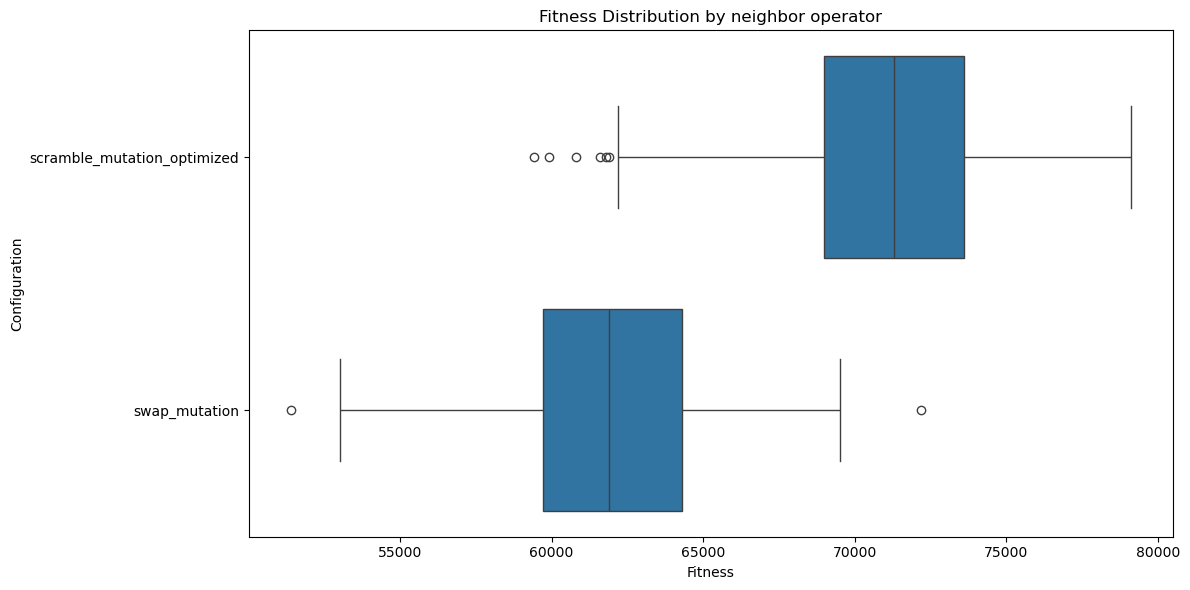

In [29]:
records = []
for _, row in df.iterrows():
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "mutation": row["neighbor"]
        })

plot_df = pd.DataFrame(records)

sorted_labels = (
    plot_df.groupby("mutation")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="mutation", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by neighbor operator")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


> In this case, the groups differ statistically, with Mann Whitney U test p-value < 0.05. <br>
> Note rank-biserial correlation evaluates the effect size. It provides an estimate of the strength and direction of the relationship between the independent groups and the outcome variable. Positive values means the first group tends to have higher ranks (higher values).



In [30]:
scramble = df_exploded[df_exploded['neighbor']=='scramble_mutation_optimized']['fitness'].values
swap = df_exploded[df_exploded['neighbor']=='swap_mutation']['fitness'].values


mann_whitney_u_test(scramble,swap,0.01)


Mann-Whitney U statistic: 672381.000
P-value: 6.841e-212
----------------------------------------------------------------------------------------------------
REJECT H0: Groups differ significantly.
Rank-biserial correlation: 0.946


### Aggregate by scramble mutation and scramble size

> Higher k factor in scramble mutation means lower scramble sizes; <br>

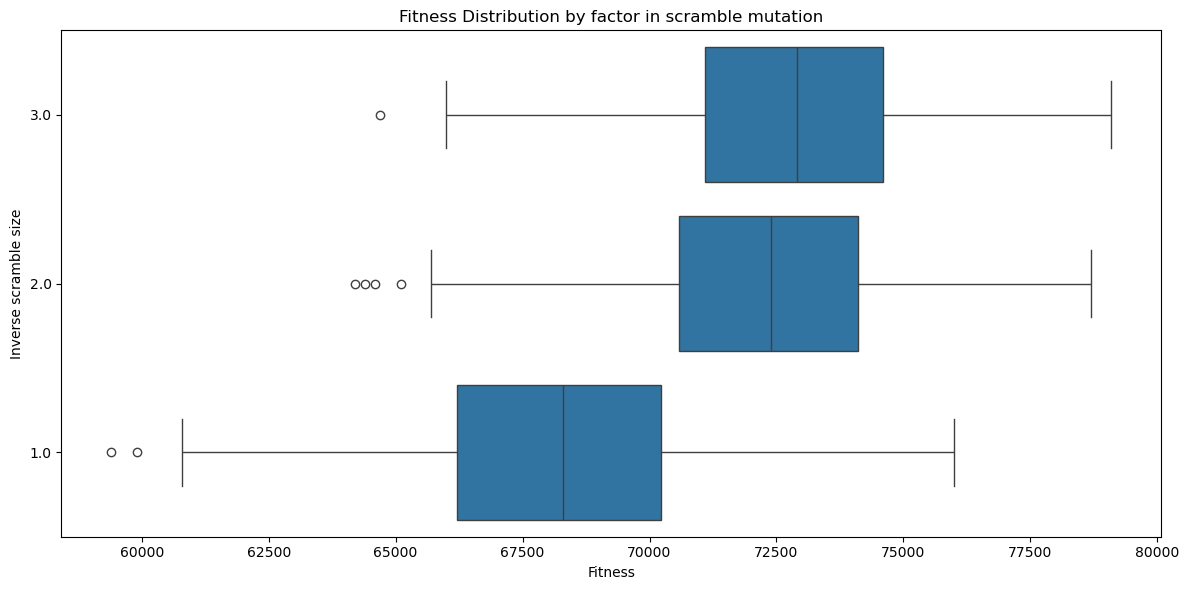

In [31]:

records = []
for _, row in df.iterrows():
    if row["neighbor"] == "swap_mutation":
        continue
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "mutation": row["neighbor"],
            "k": row["k"]
        })
    
    
plot_df = pd.DataFrame(records)

sorted_labels = (
    plot_df.groupby("k")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plot_df["k"] = plot_df["k"].astype(str)
sorted_labels = sorted_labels.astype(str)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="k", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by factor in scramble mutation")
plt.xlabel("Fitness")
plt.ylabel("Inverse scramble size")
plt.tight_layout()
plt.show()


### Aggregate by C and H value 

> When aggregating solely by the control parameter (C) and by the decay rate (H) we observe that there's significant differences for these aggregations.

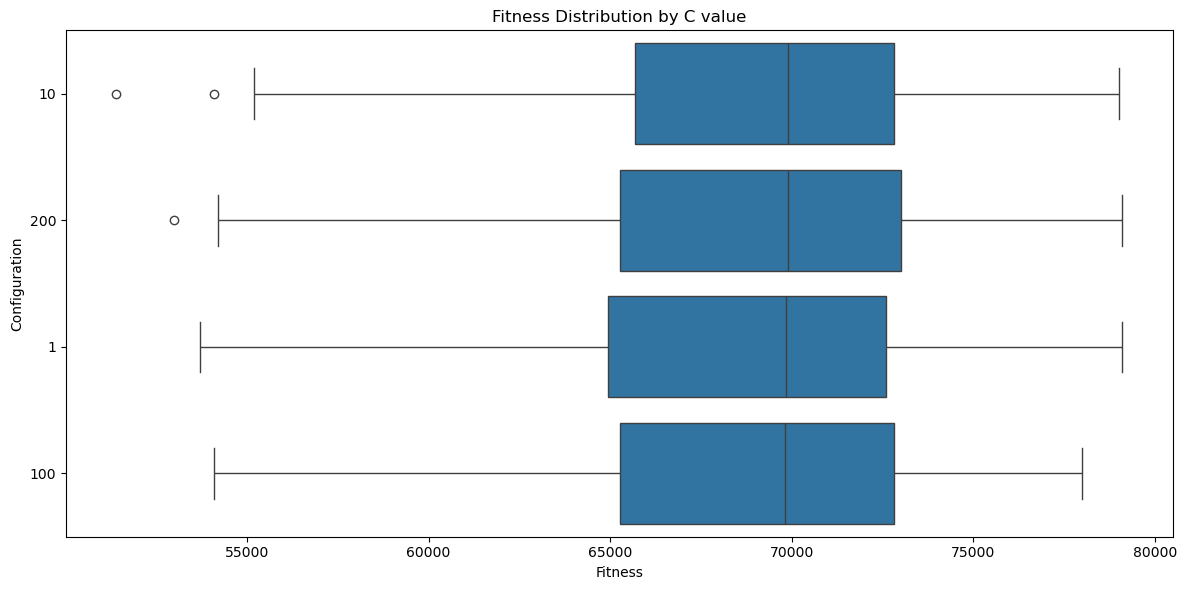

In [32]:
records = []
for _, row in df.iterrows():
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "C": row["C"]
        })
        
plot_df = pd.DataFrame(records)


sorted_labels = (
    plot_df.groupby("C")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plot_df["C"] = plot_df["C"].astype(str)
sorted_labels = sorted_labels.astype(str)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="C", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by C value")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


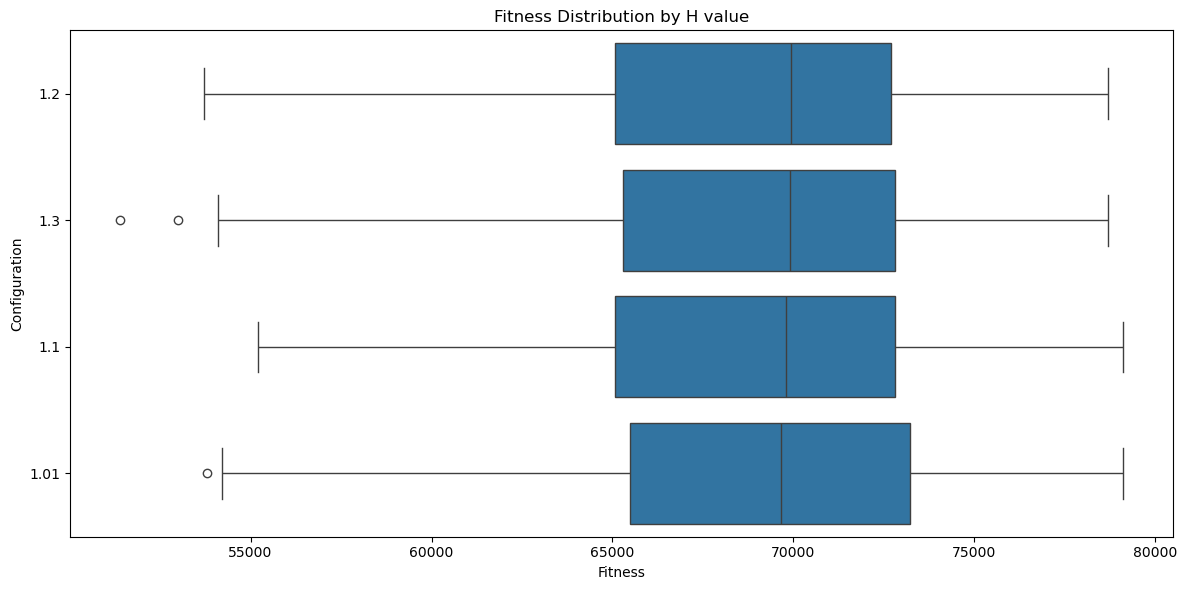

In [33]:
records = []
for _, row in df.iterrows():
    label = f"{row['neighbor']} ({row['k']}) | C={row['C']} | H={row['H']}"
    for fitness in row["fitness_list"]:
        records.append({
            "configuration": label,
            "fitness": fitness,
            "H": row["H"]
        })
    
plot_df = pd.DataFrame(records)

sorted_labels = (
    plot_df.groupby("H")["fitness"]
    .median()
    .sort_values(ascending=False)
    .index
)

plot_df["H"] = plot_df["H"].astype(str)
sorted_labels = sorted_labels.astype(str)

plt.figure(figsize=(12, max(6, 0.4 * len(sorted_labels))))
sns.boxplot(data=plot_df, y="H", x="fitness", order=sorted_labels)
plt.title("Fitness Distribution by H value")
plt.xlabel("Fitness")
plt.ylabel("Configuration")
plt.tight_layout()
plt.show()


# Top performing configurations (100 episodes)

> Now we will present the results for the top 10 performing configurations and top performing configuration each mutation operator and each scramble size (k values) <br>
> Each test was ran 100 times; with 10_000 fitness evaluations (100 iterations * 100 inner loop - L - for local search).


In [34]:
results_file = "results/avg_fitness_by_generation_sa.csv"

final_res = pd.read_csv(results_file)

final_res["fitness_by_gen"] = final_res["fitness_by_gen"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_by_gen"].apply(lambda x: x[-1])

final_res["best_fitness"] = final_res["best_fitness"].apply(json.loads)

final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)

df_exploded = final_res_sorted.explode("best_fitness")

In [35]:
df_exploded

,configuration,fitness_by_gen,best_fitness,final_fitness
4,"(100, 100, 'scramble_mutation_optimized', 3.0,...","[11750.0, 23300.0, 30300.0, 35000.0, 38950.0, ...",76900.0,76050.0
4,"(100, 100, 'scramble_mutation_optimized', 3.0,...","[11750.0, 23300.0, 30300.0, 35000.0, 38950.0, ...",75700.0,76050.0
4,"(100, 100, 'scramble_mutation_optimized', 3.0,...","[11750.0, 23300.0, 30300.0, 35000.0, 38950.0, ...",79600.0,76050.0
4,"(100, 100, 'scramble_mutation_optimized', 3.0,...","[11750.0, 23300.0, 30300.0, 35000.0, 38950.0, ...",76200.0,76050.0
4,"(100, 100, 'scramble_mutation_optimized', 3.0,...","[11750.0, 23300.0, 30300.0, 35000.0, 38950.0, ...",76700.0,76050.0
...,...,...,...,...
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...","[12350.0, 26000.0, 31150.0, 34300.0, 37550.0, ...",72400.0,72750.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...","[12350.0, 26000.0, 31150.0, 34300.0, 37550.0, ...",70000.0,72750.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...","[12350.0, 26000.0, 31150.0, 34300.0, 37550.0, ...",73900.0,72750.0
11,"(100, 100, 'scramble_mutation_optimized', 1.0,...","[12350.0, 26000.0, 31150.0, 34300.0, 37550.0, ...",72100.0,72750.0


> As the generations increase (from generation 50 until 200) a higher scramble size (k=1, dark blue line) achieve a better significant better fitness than smaller sizes, probably by allowing continuous exploration of the local search space.

> A small scramble sizes (k=2 and k=3) with a relative high C value (C=10, 200) (orange line and light blue lines) result in a decrease of fitness of the current solution after 150 iterations, probably small capacity of exploration of the local search space (smaller k values) with a high probability of accepting worse solutions (high C value) at low temperatures (after 150 iterations).  

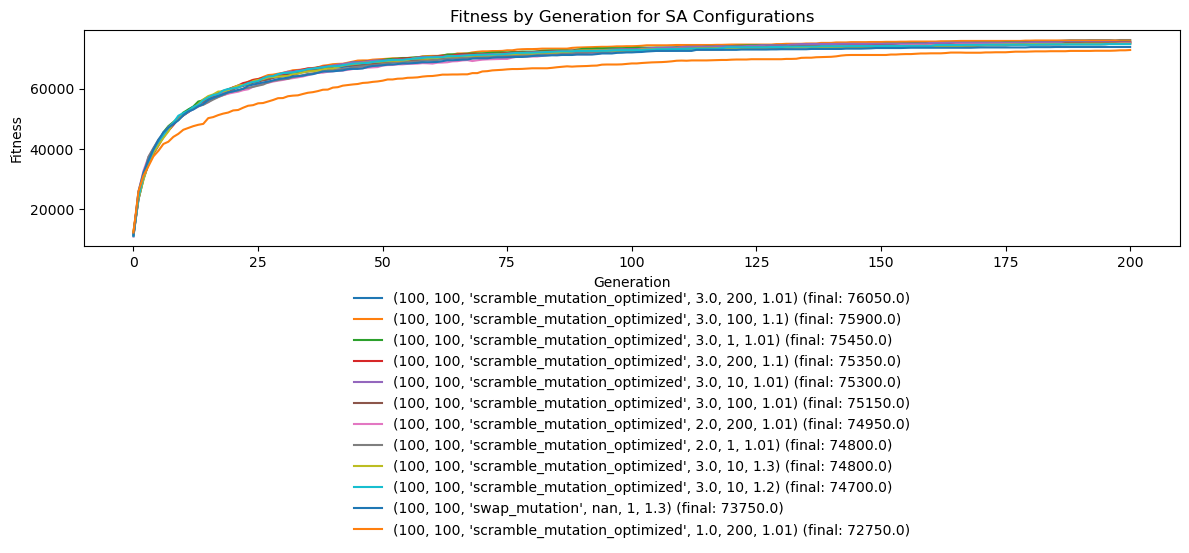

"(100, 100, 'scramble_mutation_optimized', 3.0, 200, 1.01)"

In [36]:

plt.figure(figsize=(12, max(6, 0.4 * len(final_res_sorted))))
for _, row in final_res_sorted.iterrows():
    fitness_curve = row["fitness_by_gen"]
    label = f"{row['configuration']} (final: {row['final_fitness']})"
    plt.plot(fitness_curve, label=label)
    
plt.title("Fitness by Generation for SA Configurations")
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False)
plt.tight_layout()
plt.show()


best_config = final_res_sorted.iloc[0]
best_config["configuration"]


> The top performing configuration is also the one with less variance, while having the higher scramble size (k = 1). <br>While this seem counterintuitive, it might be related to the fact the the higher exploratory power with bigger scramble sizes alow the model to stabilize more often in good solutions.

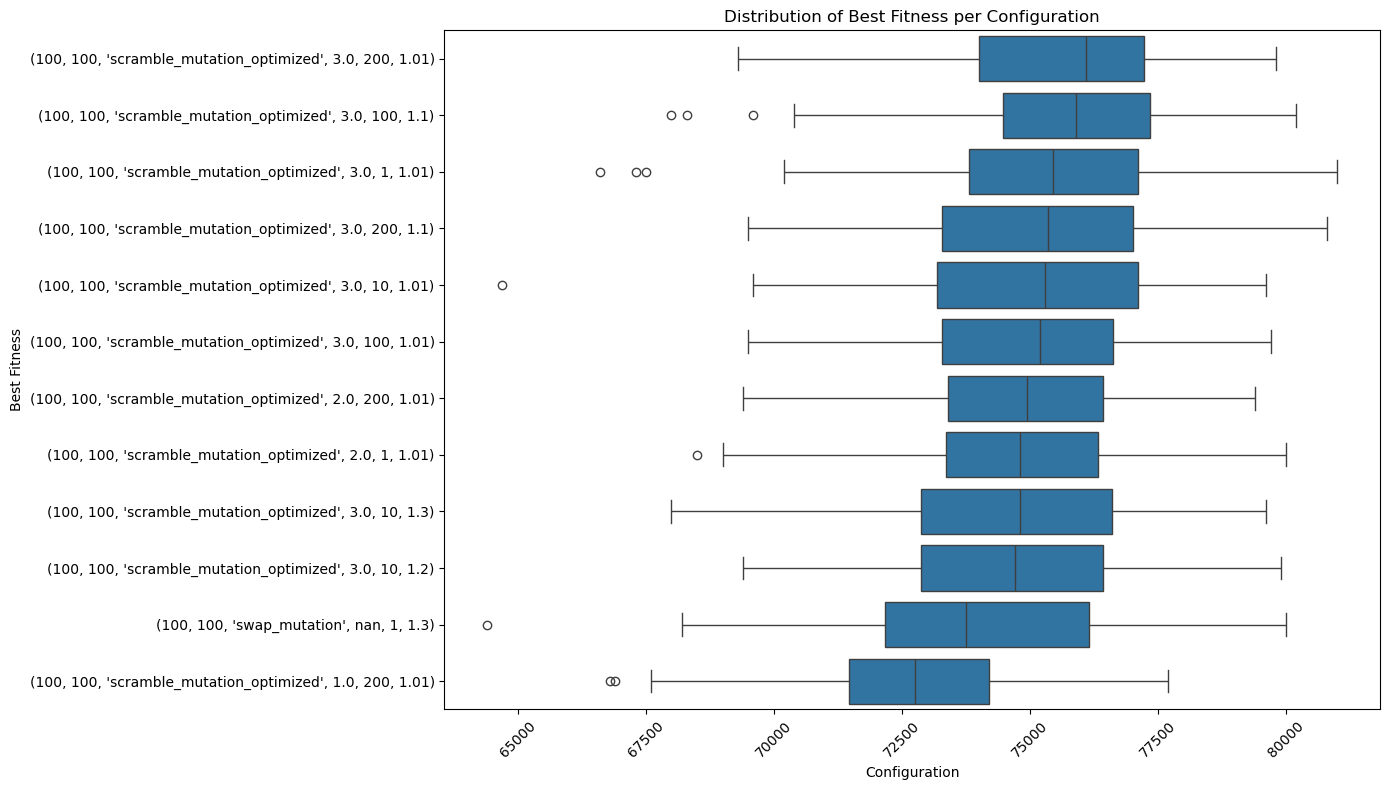

In [37]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_exploded, y="configuration", x="best_fitness",)
sns.boxplot()
plt.title("Distribution of Best Fitness per Configuration")
plt.xlabel("Configuration")
plt.ylabel("Best Fitness")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
df_exploded = (
    final_res_sorted[["configuration", "best_fitness"]]
    .explode("best_fitness")
)

config_groups = [
    grp["best_fitness"].values
    for _, grp in df_exploded.groupby("configuration", observed=True)
]
kruskal_wallis_test(config_groups)

Kruskal-Wallis H-test statistic: 101.075
P-value: 1.093e-16
Eta-squared effect size (η²): 0.076
----------------------------------------------------------------------------------------------------
REJECT H0: At least one configuration has significantly different fitness scores.


> The top configuration overperforms other configurations with statistically significant differences.

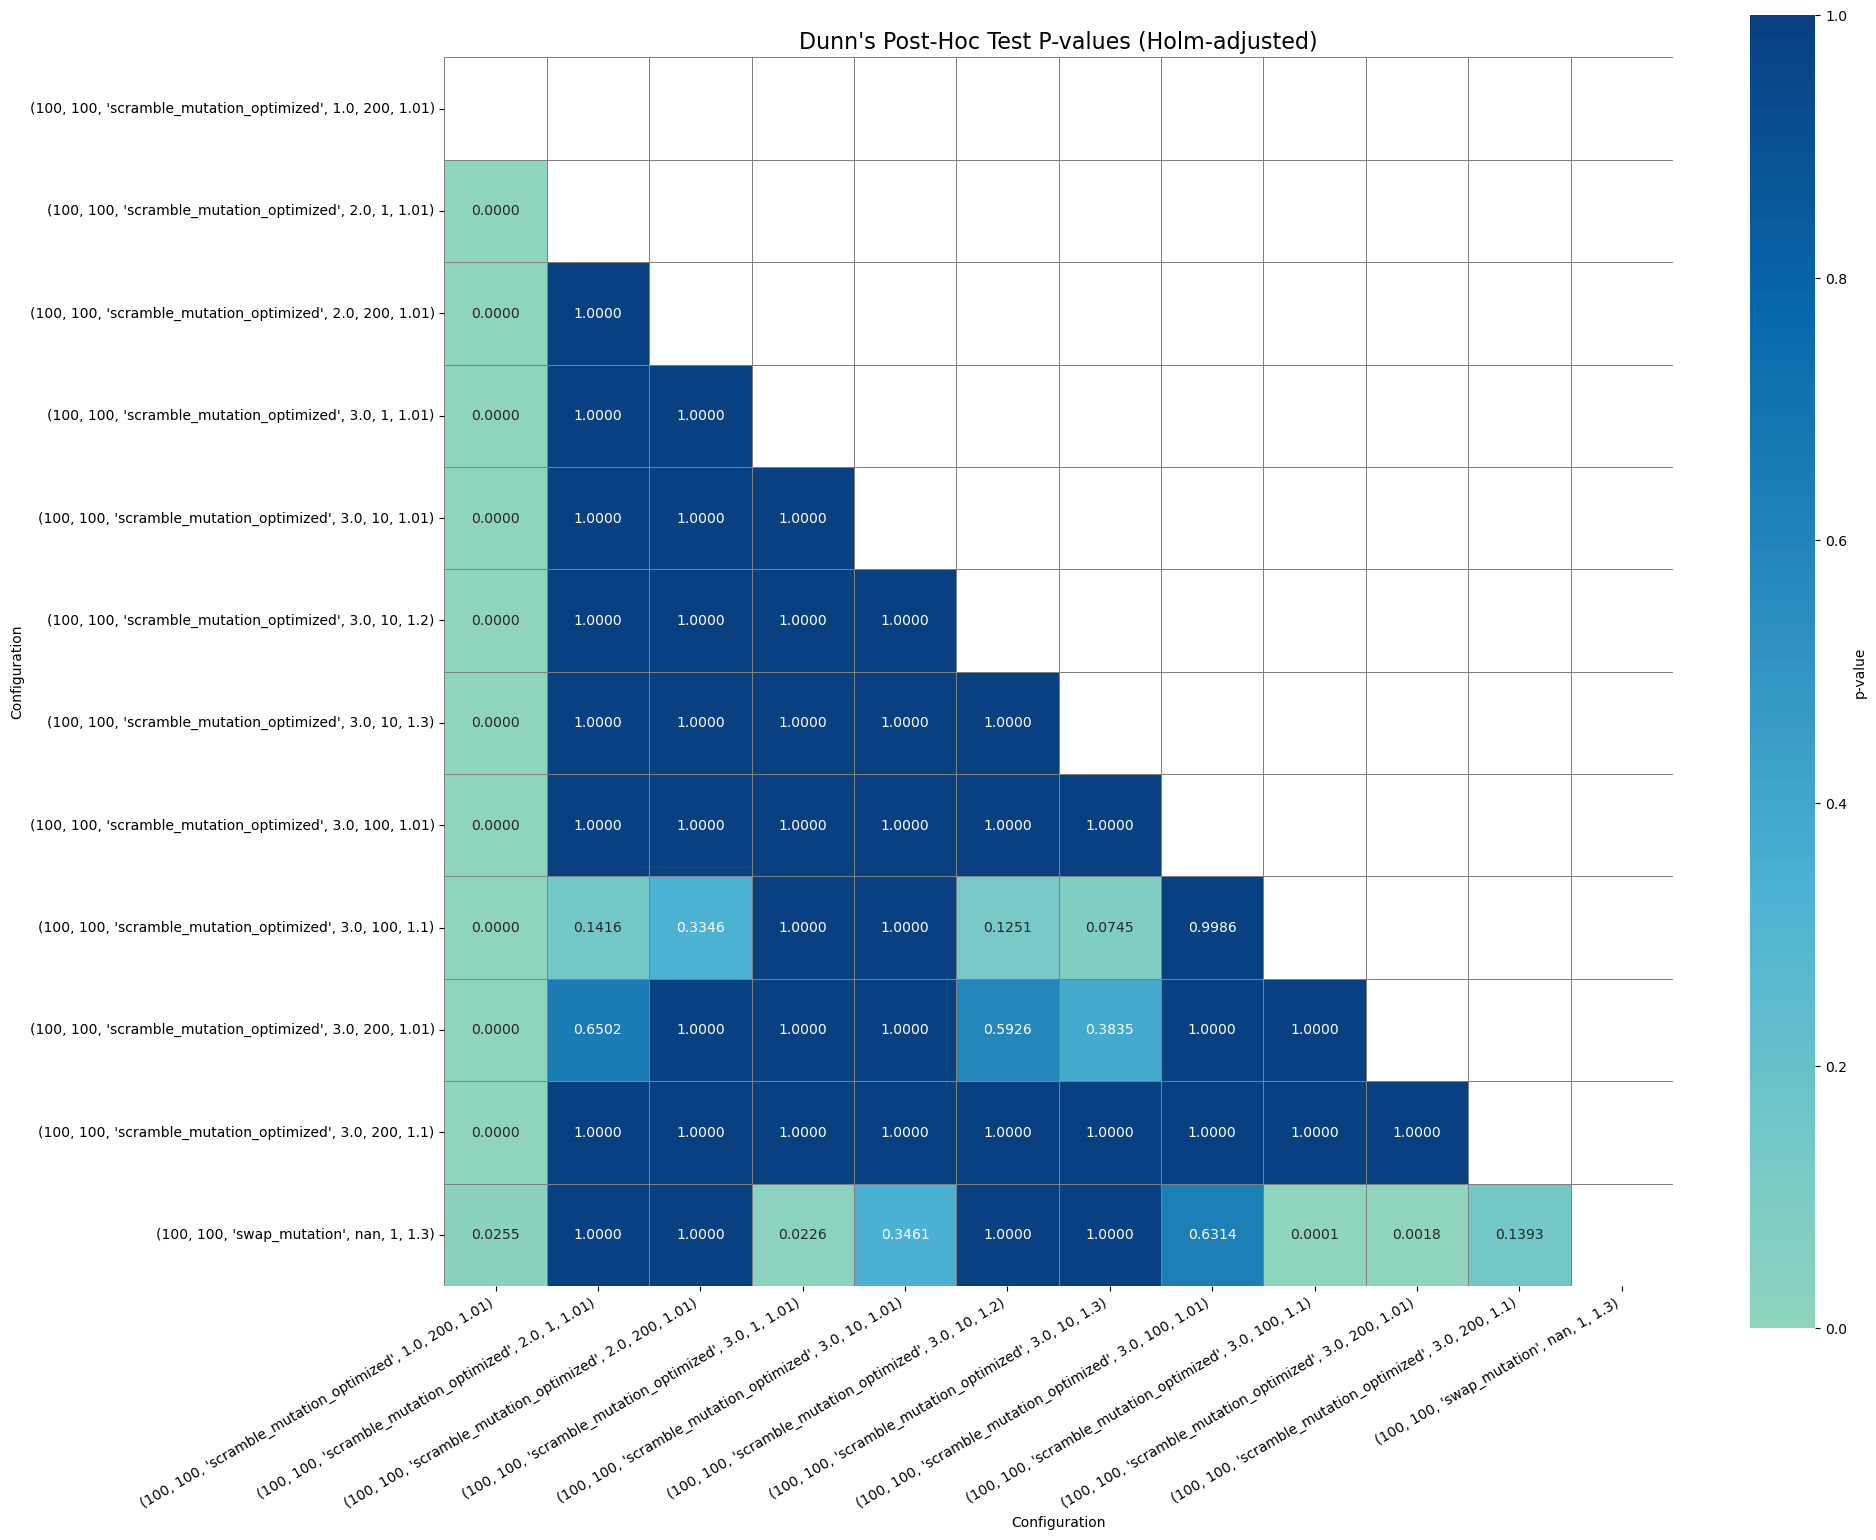

In [39]:
dunn_results= run_dunn_posthoc(df_exploded, 'best_fitness', 'configuration','holm')
plot_dunn_results(dunn_results)